# Are weakly activated neurons are the source of instabilities in different methods? Are they still relevant?

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm
import copy
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

import quantus

from util.util_cnn import CNNModel, data_loaders, test, \
                params_to_filename, params_from_filename, \
                load_mnist_v4_models, first_mnist_batch

from util.util_gamma_rule import \
                forw_surrogate_matrix,  \
                back_matrix, \
                global_conv_matrix_from_pytorch_layer, \
                calc_evals_batch, \
                calc_vals_batch, \
                smart_gamma_wo_sign_flips, \
                col_norms_for_matrices

from util.quantus import *

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer, Conv2dAsMatrixLayer

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_data_summary import *
import util.util_tutorial as tut_utils

from util.naming import *
from util.util_pickle import *
from util.common import *

### Load models

In [3]:
# load v4 models
model_dict = load_mnist_v4_models()

# models_1 = {k:v for (k,v) in model_dict.items() if 'cb1-8' in k and 'seed-0' in k}
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
model = model_d3

### Load data

In [4]:
data, target = first_mnist_batch(batch_size=100)

A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

Attempt loading: mnist first_batch_1000


## How does the condition change when excluding weakly activated neurons?

lines
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p080
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p080
Attempt loading: d3 svals__15_to_0__testset100__ig50__p080
Attempt loading: d3 svals__15_to_0__testset100__shap__background_size-100__batch_size-10__p080


<Figure size 640x480 with 0 Axes>

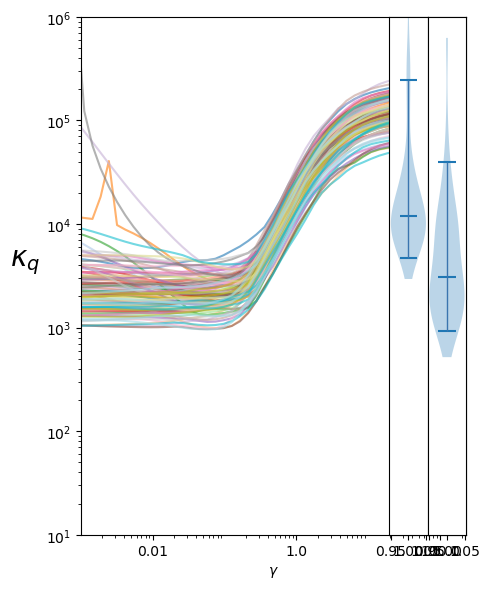

In [122]:
first_p = 80
# ^^ I have 40, 80, 90, 100 (None)

key = 'svals__15_to_0__testset100'

lrp_config = '__all_gamma__gammas80'
ig_config = '__ig50'
shap_config = '__shap__background_size-100__batch_size-10'

appendix = ''
if first_p: appendix = f'__p{first_p:03}'

plot_cond(key+lrp_config+appendix, ylim=(1e2, 1e6), xlim=(1, 1e2), percentile=(0, .1))

ax_log = plt.gca()
ax_log.set_xlim(1e-3, 1e2*2.3)
ax_log.set_ylim(1e1, 1e6)

## violin plots for shap and ig

axin1 = ax_log.inset_axes([.8, 0, .1, 1])
axin2 = ax_log.inset_axes([.9, 0, .1, 1])
axin1.yaxis.set_visible(False)
axin2.yaxis.set_visible(False)
axin1.set_ylim(*transform_yscale(ax_log.get_ylim()))
axin2.set_ylim(*transform_yscale(ax_log.get_ylim()))

pos, widths = [1], [.1]

data = condition_number(('d3', key+ig_config+appendix), gammas=[0])[0, :n_points, -1:].T # IG: the integration up to the zero image is the last one
add_violin(axin1, data, pos, widths)

data = condition_number(('d3', key+shap_config+appendix), gammas=[0])[0, :n_points, :1].T            # SHAP: only has one parametrisation
add_violin(axin2, data, pos, widths)

### How do the Singular values change when masking weakly activated neurons?
- Both high and low Singular values dissappear
- Thus we do not only cut away tiny dimensions
- Thus the decrease in Condition number is significant

Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p080
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p090
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p080
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p090
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p080
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80__p090
Attempt loading: d3 svals__15_to_0__testset100__all_gamma__gammas80
Attempt loading: d3 svals__15_to_0__testset100__ig50__p080
Attempt loading: d3 svals__15_to_0__testset100__ig50__p090
Attempt loading: d3 svals__15_to_0__testset100__ig50
Attempt loading: d3 svals__15_to_0__testset100__shap__background_size-100__batch_size-10__p080
Attempt loading: d3 svals__15_to_0__testset100__shap__background_size-100__batch_size-

Text(0, 0.5, 'Distribution of all Svals of 100 datapoints (log-scaled)')

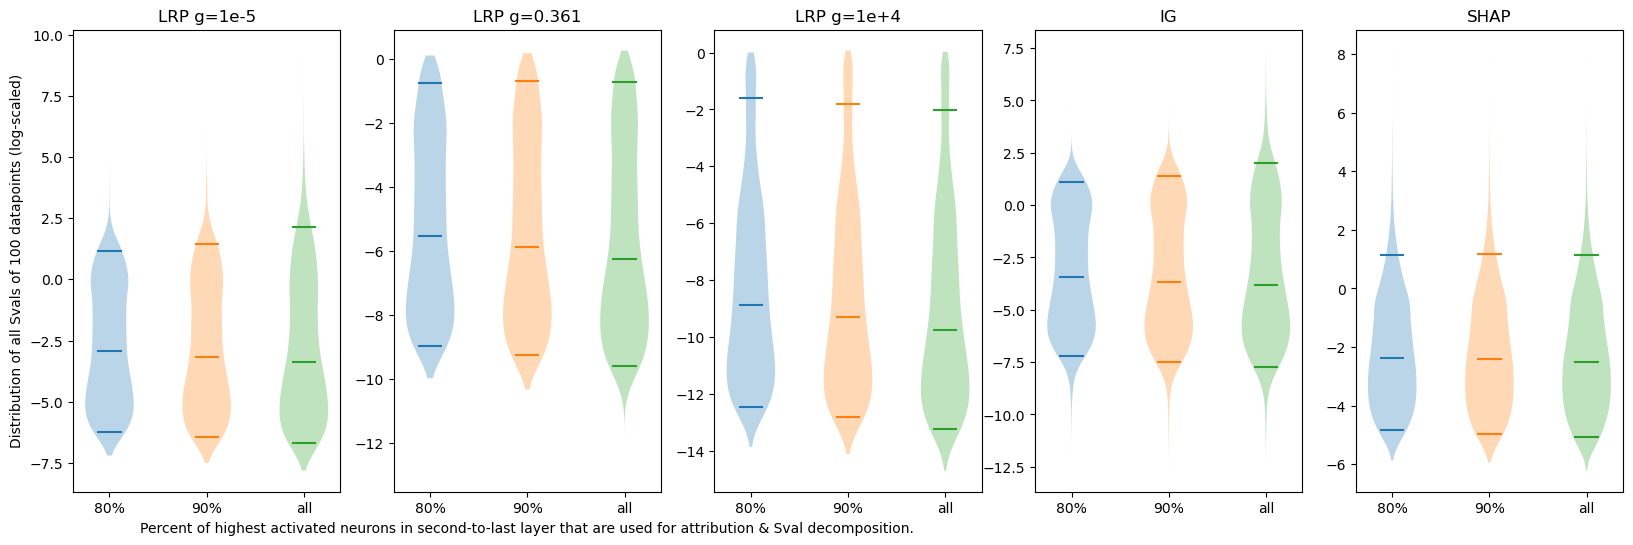

In [229]:
first_ps = 40, 80, 90, None
first_ps = 80, 90, None
p_lbls = ['80%', '90%', 'all']

scale = .2

key = 'svals__15_to_0__testset100'

lrp_config = '__all_gamma__gammas80'
ig_config = '__ig50'
shap_config = '__shap__background_size-100__batch_size-10'

configs = [(lrp_config, i_gamma) for i_gamma in (0, 40, 79)] \
        + [(config, -1) for config in (ig_config, shap_config)]
n_c = len(configs)

fig, axs = plt.subplots(1, n_c, figsize=(n_c*4, 6))

for ax, (conf_str, i_parametrisation) in zip(axs, configs):
    lbl = ''
    if 'ig'    in conf_str: lbl = 'IG'
    if 'shap'  in conf_str: lbl = 'SHAP'
    if 'gamma' in conf_str: lbl = f'LRP g={pretty_num(gammas80[i_parametrisation])}'
    
    for i, first_p in enumerate(first_ps):
        appendix = ''
        if first_p: appendix = f'__p{first_p:03}'

        svals = load_data('d3', key+conf_str+appendix)
        svals = svals[0, :, i_parametrisation].flatten()
        
        svals = svals[svals != 0]
        # data.append(svals)
        add_violin(ax, svals, [i*scale], [.1])
        
        ax.set_xticks(np.arange(len(first_ps))*scale, p_lbls)
        ax.set_title(lbl)
        
axs[1].set_xlabel('Percent of highest activated neurons in second-to-last layer that are used for attribution & Sval decomposition.')
axs[0].set_ylabel('Distribution of all Svals of 100 datapoints (log-scaled)')

## How do the heatmaps change?
- The weakly activated neurons are the source of instability. But would they even have an influence on generated heatmaps?
- To find out we plot/analyze heatmaps explaining all (or top 80%) of neurons at the same time - but weighted by their activation.

### Gather data

In [25]:
i_gamma = 40
i_gamma = 40
i_feature = 0

first_ps = 40, 80, 90, None
first_ps = 80, 90, None
p_lbls = ['80%', '90%', 'all']
is_correction = [0, 1, 2]

n_f = 4 # num of features
n_p = len(first_ps)

scale = .2

key = 'mats__15_to_0__testset100'

lrp_config = '__all_gamma__gammas80'
ig_config = '__ig50'
shap_config = '__shap__background_size-100__batch_size-10'

configs = [(lrp_config, i_gamma) for i_gamma in (0, 40, 79)] \
        + [(config, -1) for config in (ig_config, shap_config)]
n_c = len(configs)

from util.data_wrangling import mask_by_activations
get_mask = lambda first_p, i_point: mask_by_activations(mat=None, outputs=A[15][i_point].flatten(), first_p=first_p, prefilter_positive_activations=True, return_only_masks_and_outputs=True)[0]
masks = [[get_mask(first_p, i) for i in range(100)] for first_p in first_ps]

In [118]:
n_points = 100

heatmaps = np.zeros(
    (
    n_c, # configs (methods and their parametrisations)
    n_p, # first_ps
    n_points, # points
    256, # number of features (maximum, some will remain unoccupied)
    784), 
    dtype=float)

for i_config, (conf_str, i_parametrisation) in enumerate(configs):
    for i_first_p in range(n_p):
        first_p, p_lbl = first_ps[i_first_p], p_lbls[i_first_p]
        appendix = ''
        if first_p: appendix = f'__p{first_p:03}'

        mats = load_data('d3', key+conf_str+appendix)
        
        for i_point in range(n_points):
            heatmaps[i_config, i_first_p, i_point, masks[i_first_p][i_point], :] = mats[0][i_point, i_parametrisation]
    
config_lbls = []
        
for conf_str, i_parametrisation in configs:
    lbl = ''
    if 'ig'    in conf_str: lbl = 'IG'
    if 'shap'  in conf_str: lbl = 'SHAP'
    if 'gamma' in conf_str: lbl = f'LRP g={pretty_num(gammas80[i_parametrisation])}'
    config_lbls.append(lbl)

0.6127213541666666 [0. 1.]


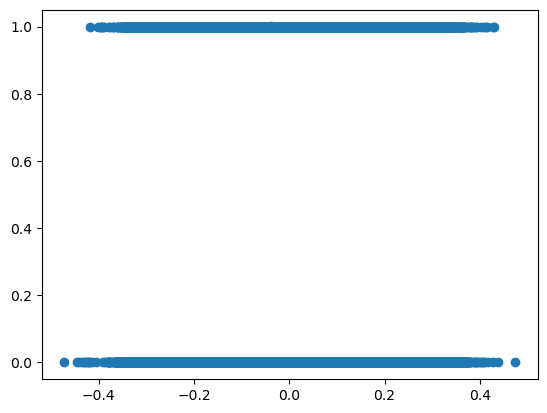

In [126]:
# check that things are properly normalized up to this point
summed = heatmaps.sum(axis=-1).flatten()
rounded = summed.round(3)

print((rounded == 0).mean(), np.unique(rounded))

x = np.random.normal(0, .1, len(summed))
plt.scatter(x, summed)

### visually / qualitatively inspect the heatmaps

the heatmaps show the explanation of *all neurons at the same time, weighted by the activation of the neuron* 

(though the left plots restrict themselves to the top 80%/90% of activated neurons)


In [71]:
# collect feature neurons that are (not) available in all maskings
only40hasnot = (masks[-1][0].int() - masks[0][0].int()).bool()
np.arange(len(only40hasnot))[only40hasnot]

array([ 20,  41,  47,  79, 102, 108, 111, 136, 143, 145, 149, 150, 153,
       184, 185, 188, 206, 220, 222, 236, 242, 248])

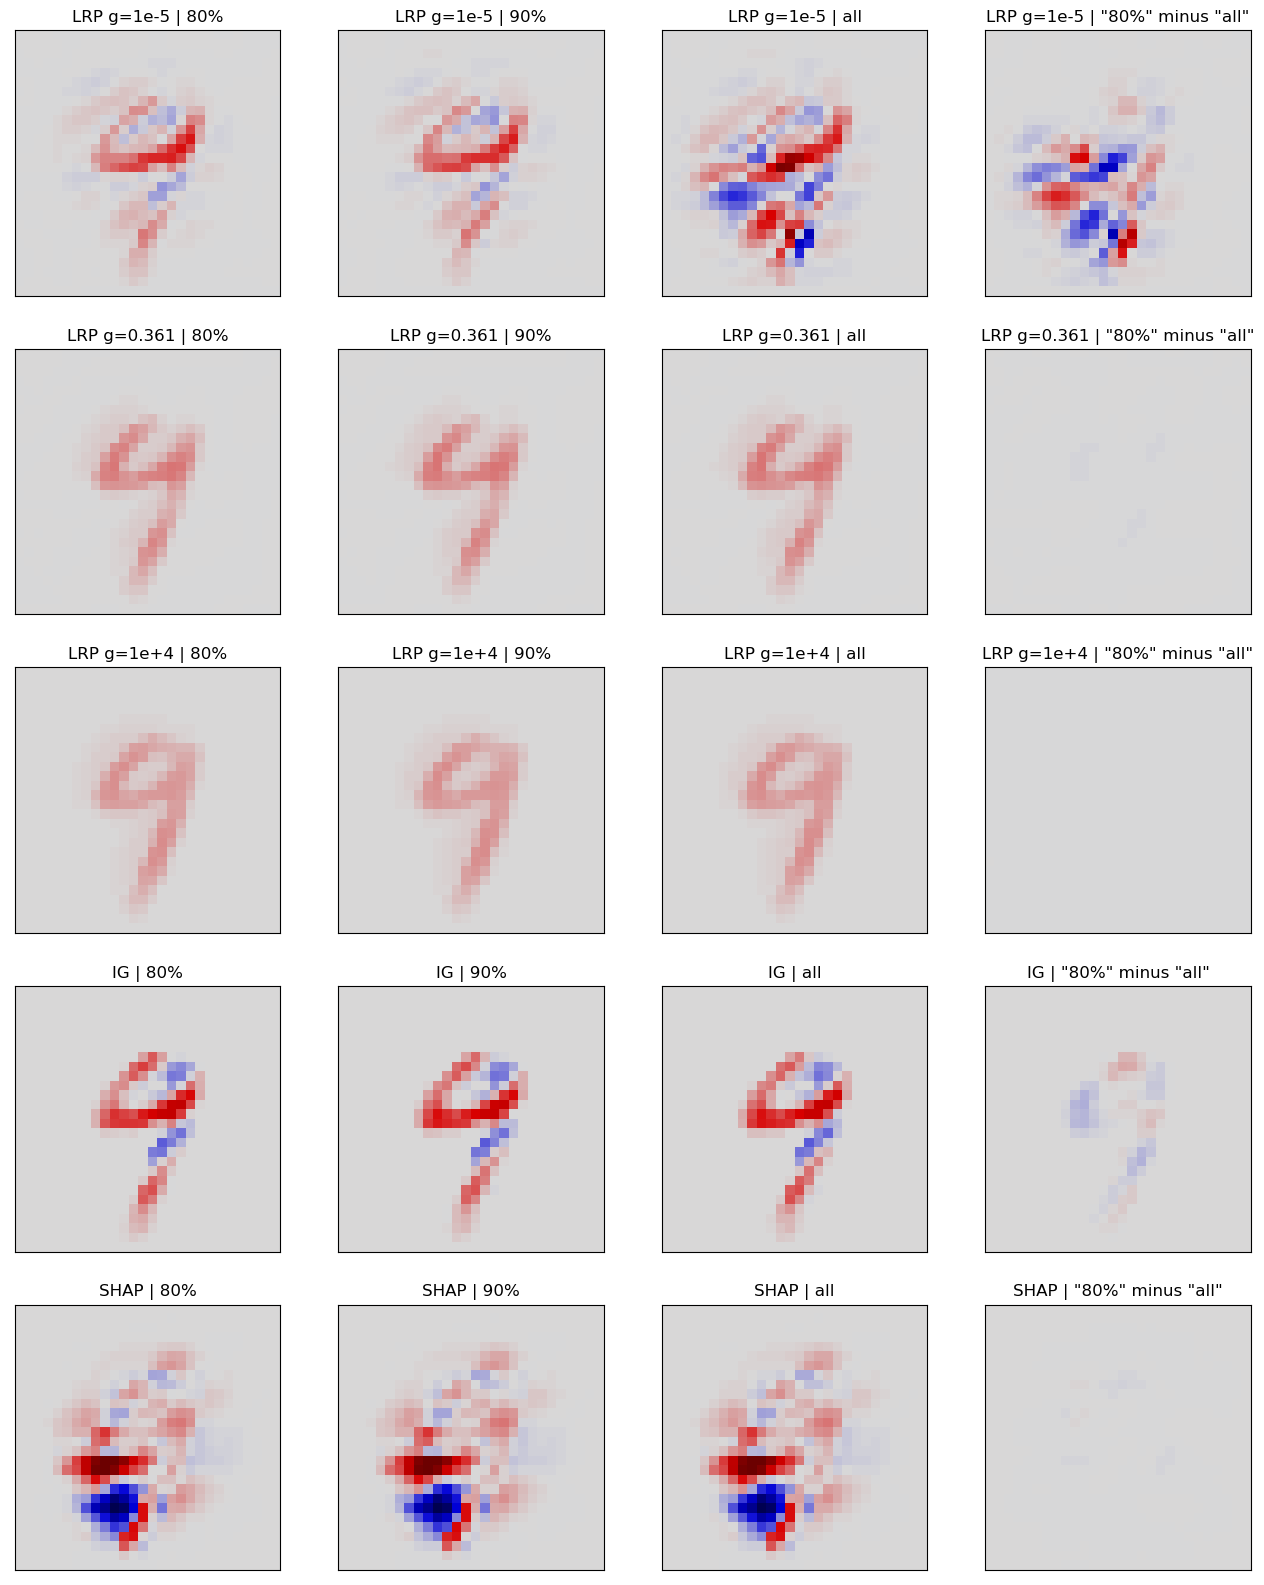

In [119]:
i_point = 2
i_feature = 20

fig, axs = plt.subplots(n_c, (n_p + 1), figsize=((n_p + 1)*4, n_c*4)) # add one column to visualize the diff

# b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
b = 20
from matplotlib.colors import ListedColormap
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

def plot_help(ax, img, title):
    ax.imshow(img,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    
for axs_row, c_lbl, heatmaps_for_config in zip(axs, config_lbls, heatmaps):
    img_per_first_p = []
    for first_p, ax, p_lbl, heatmaps_for_first_p in zip(first_ps, axs_row, p_lbls, heatmaps_for_config):
        
        activations = A[15][i_point].flatten()
        heatmaps_per_neuron = heatmaps_for_first_p[i_point]
        
        img = heatmaps_per_neuron[i_feature]
        img = activations @ heatmaps_per_neuron
        
        img = img.reshape((28, 28))
        plot_help(ax, img, f'{c_lbl} | {p_lbl}')
        img_per_first_p.append(img)
        
    ax = axs_row[-1]
    img = img_per_first_p[0] - img_per_first_p[-1]
    p_lbl = f'"{p_lbls[0]}" minus "{p_lbls[-1]}"'
    plot_help(ax, img, f'{c_lbl} | {p_lbl}')
    

### empirically investigate the difference between the heatmaps

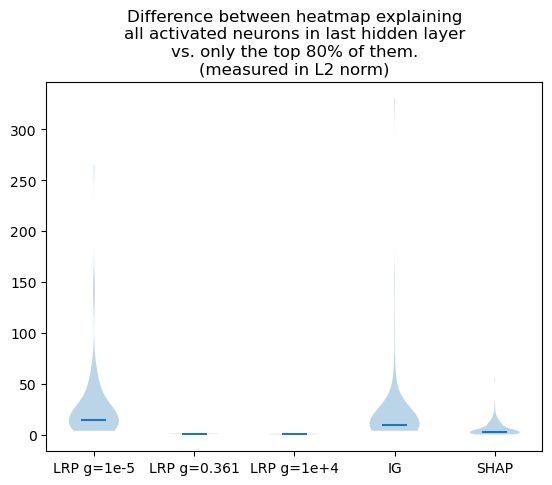

In [129]:
activations = A[15].flatten(1,3) # drop dummy dimensions
heatmaps_weighted_summed = np.einsum('abcde,cd->abce', heatmaps, activations)       # use all (or top 80%) neurons to explain all features, weighted by their activation
heatmaps_diff = heatmaps_weighted_summed[:, 0] - heatmaps_weighted_summed[:, -1]    # "80% minus all"
heatmaps_diff_magnitude = np.linalg.norm(heatmaps_diff, axis=-1, ord=2)

plt.violinplot(heatmaps_diff_magnitude.T, showmeans=False, showmedians=True, showextrema=False)
plt.title(
r"""Difference between heatmap explaining
all activated neurons in last hidden layer
vs. only the top 80% of them.
(measured in L2 norm)""")
plt.xticks(np.arange(1, 6), config_lbls);